# Redes Neuronales

Contamos con una base de datos de una compañía de telecomunicaciones, con la que la misma podrá tomar acciones dirigidas en la retención de clientes propensos a la fuga.
La base de datos cuenta con 12 atributos regresores más la etiqueta de clase, que son:

- Call Failures: Número de fallos de llamadas
- Complaints: Quejas (1) o ninguna queja (0)
- Subscription Length: Meses totales de suscripción
- Charge Amount: Importe del cargo, atributo ordinal (0: importe más bajo, 9: importe más alto)
- Seconds of Use: Segundos totales de llamadas
- Frequency of use: Número total de llamadas
- Frequency of SMS: Número total de mensajes de texto
- Distinct Called Numbers: Número total de llamadas distintas
- Age Group: Grupo de edad, atributo ordinal (1: menor edad, 5: mayor edad)
- Tariff Plan: Plan de tarifa, binario (1: pago por uso, 2: contractual)
- Status: Estado, binario (1: activo, 2: inactivo)
- Churn: Renuncia, binario (1: cancelación, 0: no cancelación) - Etiqueta de clase
- Customer Value: El valor calculado del cliente

### Actividad 1

Importa las librerías necesarias para aplicar preprocesamiento de datos, visualización y creación de un modelo de red neuronal feedforward con Keras y Tensorflow. Importa la base de datos Customer Churn.csv y realiza el preprocesamiento de los datos

In [63]:
# Bibliotecas Comunes
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mode

# Estadisticas
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import pointbiserialr

#Metricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report

# Identificación de outliers
from sklearn.ensemble import IsolationForest

# Evaluacion de Modelos y Seleccion de Features
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import Input
from keras.metrics import AUC
from keras.losses import BinaryCrossentropy


In [64]:
df = pd.read_csv("Customer Churn.csv", delimiter=",", encoding="utf-8", header=0)
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,2,1,25,721.980,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0


In [65]:
# Tipos de Datos y No Nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [66]:
# Valores Nulos
missing_values=df.apply(lambda x: sum(x.isnull()),axis=0)
print(missing_values)

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64


In [67]:
features_scalable = ["Call  Failure", "Subscription  Length", "Charge  Amount", "Seconds of Use", "Frequency of use", "Frequency of SMS", "Distinct Called Numbers", "Age Group", "Age", "Customer Value"]
features_not_scalable = ["Complains", "Tariff Plan", "Status"]
feature_target = "Churn"

In [68]:
df["Tariff Plan"] = df["Tariff Plan"].apply(lambda x: 1 if x==1 else 0)
df["Status"] = df["Status"].apply(lambda x: 1 if x==1 else 0)

In [69]:
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,0,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,0,1,25,721.980,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0


In [70]:
# Método para graficar
def plot_df_columns(
    df: pd.DataFrame,
    tipo: str = "histplot",
    figsize=(14, 8),
    kde: bool = False,
    bins_list=None,
    stat: str = "count"
):
    """
    Grafica todas las columnas numéricas de un DataFrame en subplots.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con los datos.
    tipo : {"hisplot","histplot","boxplot"}
        Tipo de gráfico por subplot. Se acepta el typo "hisplot" (histplot).
    figsize : tuple
        Tamaño de la figura en pulgadas (ancho, alto) para plt.subplots.
    kde : bool
        Si True, añade curva KDE en histplot. Ignorado en boxplot.
    bins_list : list | None
        Lista con los bins a usar para cada columna (solo histplot).
        - Puede contener enteros, secuencias de bordes, o None.
        - Si la lista es más corta que el número de columnas, las
          faltantes usarán "auto".
    stat : {"count","frequency","density","probability"}
        Estadístico para histplot (ignorado en boxplot).
    """
    # Copia de trabajo
    df_ = df.copy()

    # Normalizar tipo
    tipo = (tipo or "").lower().strip()
    if tipo == "hisplot":  # aceptar el typo pedido
        tipo = "histplot"
    if tipo not in {"histplot", "boxplot"}:
        raise ValueError('tipo debe ser "hisplot"/"histplot" o "boxplot".')

    # Solo columnas numéricas (ambos gráficos requieren datos numéricos)
    cols = df_.select_dtypes(include=[np.number]).columns.tolist()
    if len(cols) == 0:
        raise ValueError("No hay columnas numéricas para graficar.")

    n = len(cols)
    # Distribuir subplots en una cuadrícula "cuadrada"
    ncols = math.ceil(math.sqrt(n))
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])

    # Preparar bins por columna si corresponde
    if bins_list is None:
        bins_list = []
    # Asegurar longitud
    if len(bins_list) < n:
        bins_list = list(bins_list) + ["auto"] * (n - len(bins_list))

    for i, col in enumerate(cols):
        ax = axes[i]
        serie = df_[col].dropna()

        if tipo == "histplot":
            bins = bins_list[i]
            sns.histplot(serie, bins=bins, kde=kde, stat=stat, ax=ax)
        else:  # boxplot
            sns.boxplot(x=serie, ax=ax)

        ax.set_title(str(col))

    # Ocultar axes no usados si la rejilla es más grande que n
    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [71]:
features_scalable

['Call  Failure',
 'Subscription  Length',
 'Charge  Amount',
 'Seconds of Use',
 'Frequency of use',
 'Frequency of SMS',
 'Distinct Called Numbers',
 'Age Group',
 'Age',
 'Customer Value']

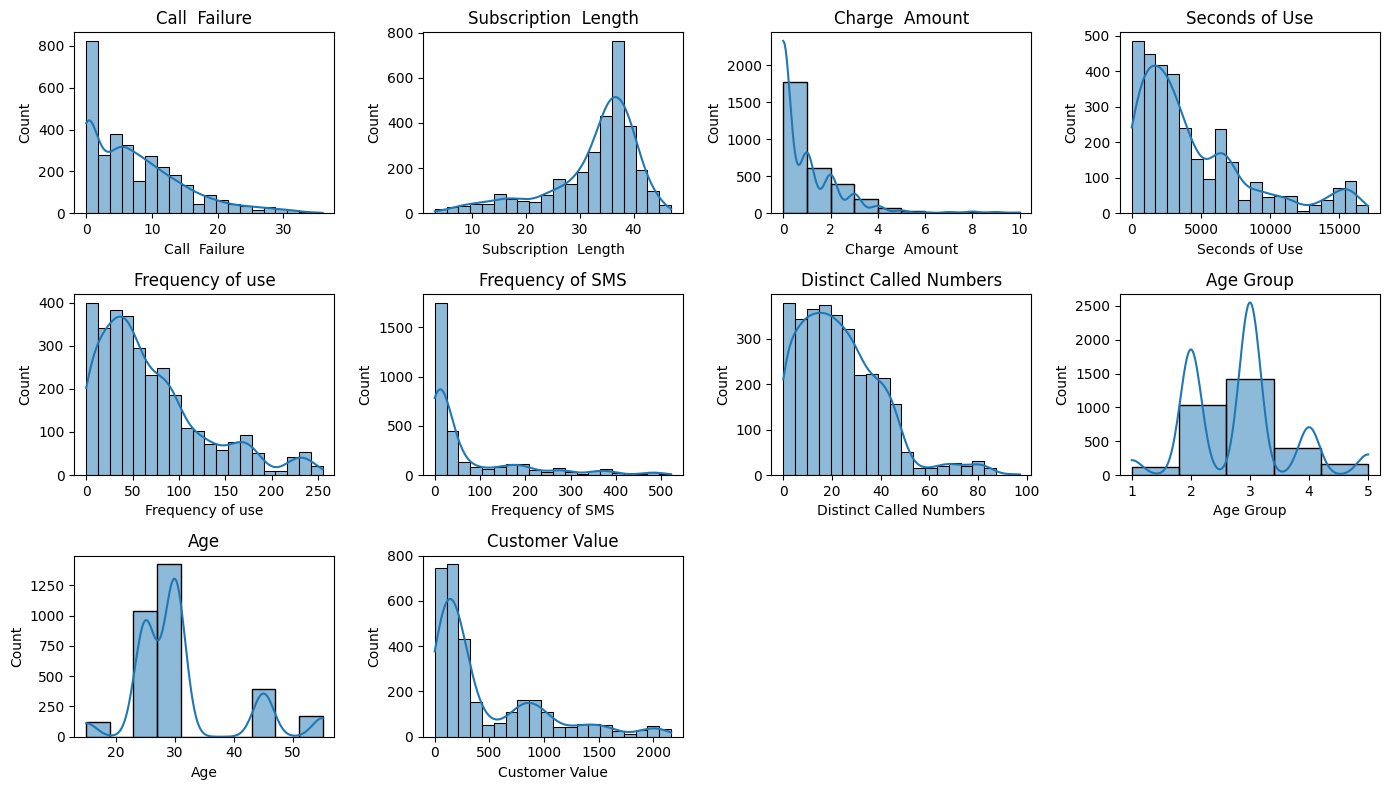

In [72]:
# Graficando histogramas para columnas numericas continuas (No categóricas)

plot_df_columns(df= df[features_scalable], tipo= "histplot", figsize=(14, 8), kde= True, bins_list=[20,20,10,20,20,20,20,5,10,20], stat= "count")

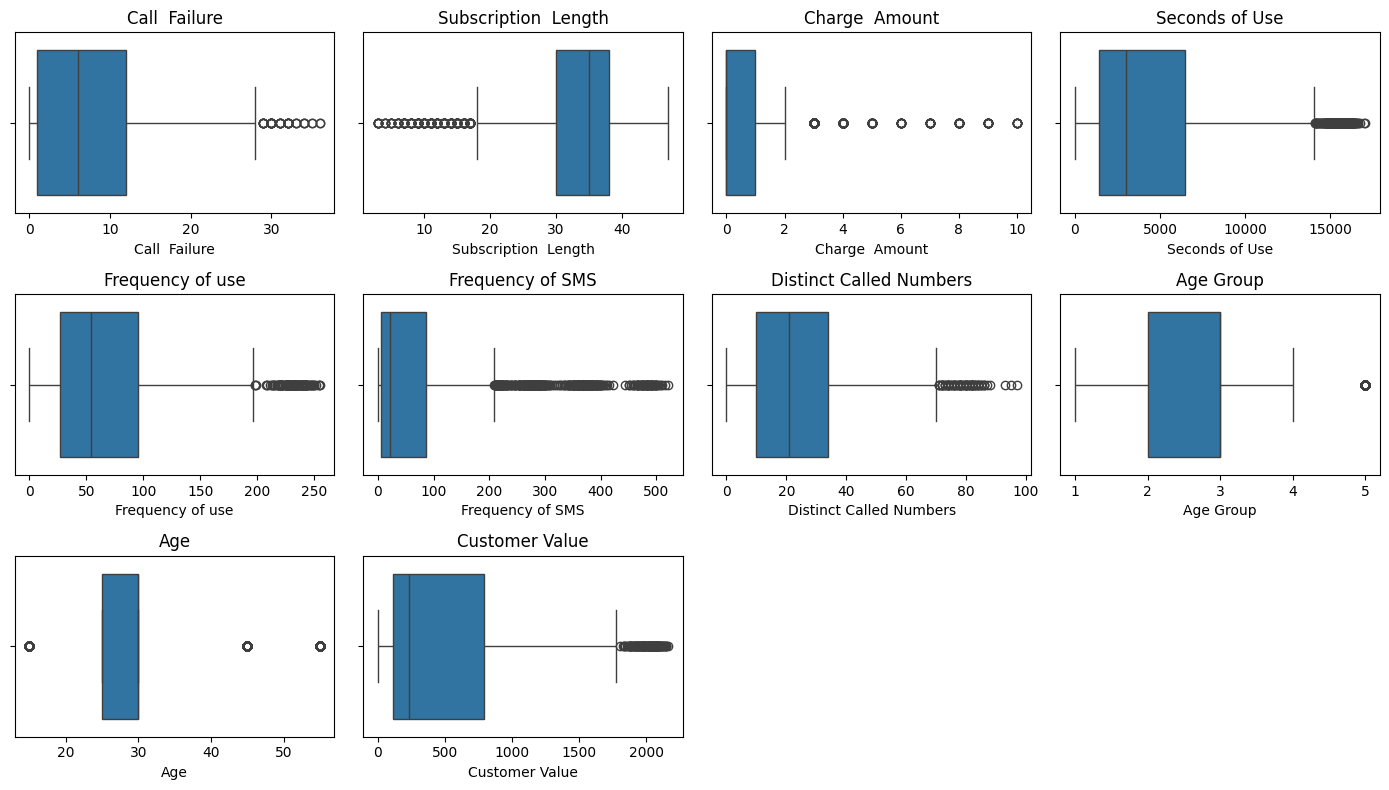

In [73]:
# Graficando boxplot para columnas numericas continuas (No categóricas)

plot_df_columns(df= df[features_scalable], tipo= "boxplot", figsize=(14, 8), kde= True, bins_list=[20,20,10,20,20,20,20,5,10,20], stat= "count")

### Actividad 2

Analiza la distribución de “Subscription Length” para cada clase (Churn), describiendo si hay alguna incidencia de esta variable en la renuncia o no. Realiza una estandarización de las variables regresoras

In [74]:
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,0,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,0,1,25,721.980,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0


In [75]:
# Creando máscaras para seleccionar valores según churn 1 ó 0
subscription_length_churn_mask_0 = df['Churn'] == 0
subscription_length_churn_mask_1 = df['Churn'] == 1

In [76]:
print(f"Cantidad de muestras con churn = 0: {subscription_length_churn_mask_0.sum()}")
print(f"Cantidad de muestras con churn = 1: {subscription_length_churn_mask_1.sum()}")


Cantidad de muestras con churn = 0: 2655
Cantidad de muestras con churn = 1: 495


In [77]:
# Se puede observar que el dataset está desbalanceado respecto a las clases del feature objetivo

In [78]:
df["Subscription Length Churn 0"] = df['Subscription  Length'][subscription_length_churn_mask_0]
df["Subscription Length Churn 1"] = df['Subscription  Length'][subscription_length_churn_mask_1]
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn,Subscription Length Churn 0,Subscription Length Churn 1
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0,38.0,NaN
1,0,0,39,0,318,5,7,4,2,1,0,25,46.035,0,39.0,NaN
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0,37.0,NaN
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0,38.0,NaN
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0,38.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,0,1,25,721.980,0,19.0,NaN
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,0,17.0,NaN
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,0,18.0,NaN
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0,11.0,NaN


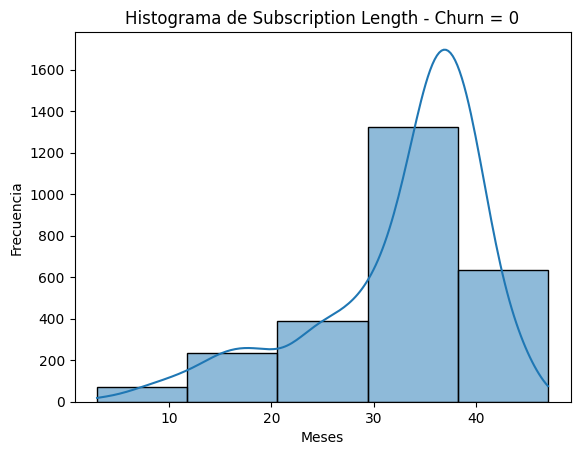

In [79]:
sns.histplot(df["Subscription Length Churn 0"], bins=5, kde=True)
plt.title("Histograma de Subscription Length - Churn = 0")
plt.xlabel("Meses")
plt.ylabel("Frecuencia")
plt.show()

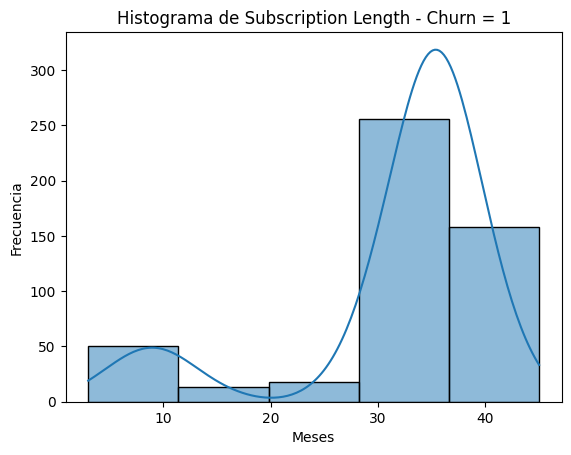

In [80]:
sns.histplot(df["Subscription Length Churn 1"], bins=5, kde=True)
plt.title("Histograma de Subscription Length - Churn = 1")
plt.xlabel("Meses")
plt.ylabel("Frecuencia")
plt.show()

In [81]:
scaler = StandardScaler()
Subscription_Length_Standard = scaler.fit_transform(df[["Subscription Length Churn 0", "Subscription Length Churn 1"]])
df_Subscription_Length_Standard = pd.DataFrame(Subscription_Length_Standard, columns=["Churn 0", "Churn 1"])
df_Subscription_Length_Standard


,Churn 0,Churn 1
0,0.636112,NaN
1,0.755291,NaN
2,0.516934,NaN
3,0.636112,NaN
4,0.636112,NaN
...,...,...
3145,-1.628279,NaN
3146,-1.866636,NaN
3147,-1.747457,NaN
3148,-2.581707,NaN


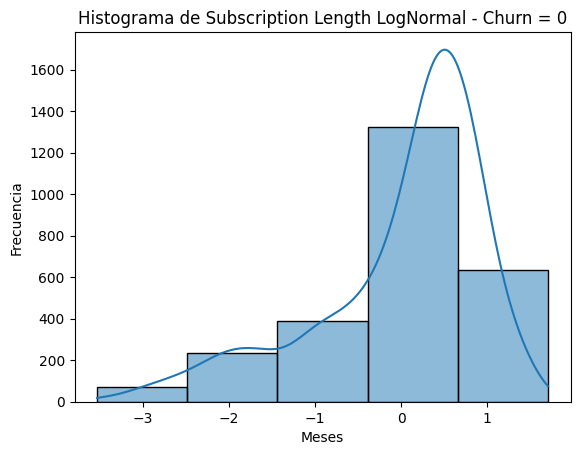

In [82]:
sns.histplot(df_Subscription_Length_Standard["Churn 0"], bins=5, kde=True)
plt.title("Histograma de Subscription Length LogNormal - Churn = 0")
plt.xlabel("Meses")
plt.ylabel("Frecuencia")
plt.show()

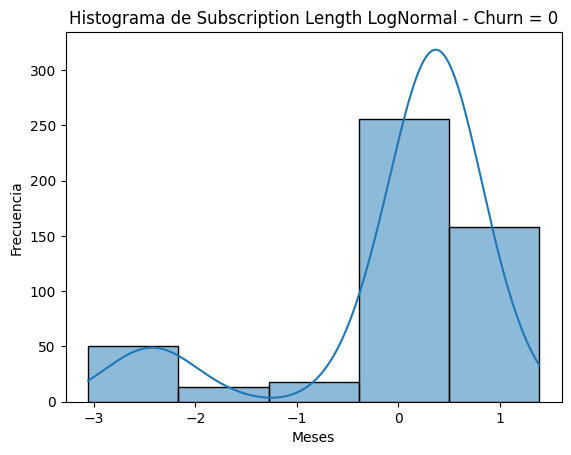

In [83]:
sns.histplot(df_Subscription_Length_Standard["Churn 1"], bins=5, kde=True)
plt.title("Histograma de Subscription Length LogNormal - Churn = 0")
plt.xlabel("Meses")
plt.ylabel("Frecuencia")
plt.show()

In [84]:
df_subscription_length_churn_0 = df[subscription_length_churn_mask_0]['Subscription  Length']
df_subscription_length_churn_1 = df[subscription_length_churn_mask_1]['Subscription  Length']

In [85]:
df_subscription_length_churn_0.describe()

count    2655.000000
mean       32.662524
std         8.392357
min         3.000000
25%        29.000000
50%        35.000000
75%        38.000000
max        47.000000
Name: Subscription  Length, dtype: float64

In [86]:
df_subscription_length_churn_1.describe()

count    495.000000
mean      31.894949
std        9.469163
min        3.000000
25%       31.000000
50%       35.000000
75%       37.000000
max       45.000000
Name: Subscription  Length, dtype: float64

In [87]:
# Aplicaremos las pruebas:
# - t de Student: Cuando las distribuciones se asemejan a una distribución Normal 
# - Mann–Whitney U: Cuando las distribuciones no se asemejan a una distribución Normal (más apropiada para este caso)
# - Probaremos si las medias de ambas muestras pueden llegar a ser iguales. 
# - En el caso que no lo sean, quiere decir que Subscription Lenght es un dato que incide en los valores de Churn
# - En el caso que las medias tiendan a ser similares, quiere decir que Subscription Lenght no es un dato que incide en los valores de Churn

In [88]:
t_stat, p_value_t_stat = ttest_ind(df_subscription_length_churn_0, df_subscription_length_churn_1, alternative='two-sided')

if(p_value_t_stat < 0.05):
    print("hay diferencia significativa → la variable numérica incide en la binaria")
else:
    print("no hay diferencia significativa → la variable numérica no incide en la binaria")

no hay diferencia significativa → la variable numérica no incide en la binaria


In [89]:
u_stat, p_value_u_stat = mannwhitneyu(df_subscription_length_churn_0, df_subscription_length_churn_1, alternative='two-sided')

if(p_value_u_stat < 0.05):
    print("hay diferencia significativa → la variable numérica incide en la binaria")
else:
    print("no hay diferencia significativa → la variable numérica no incide en la binaria")

no hay diferencia significativa → la variable numérica no incide en la binaria


In [90]:
# Correlación puntual biserial (point biserial correlation): Es una forma de Pearson modificada para una variable continua y una binaria.

r, p = pointbiserialr(df['Churn'], df['Subscription  Length'])

print(f"point biserial correlation: {r}")

point biserial correlation: -0.03258789382847445


In [91]:
df = df.drop(["Subscription Length Churn 0", "Subscription Length Churn 1"],axis=1)

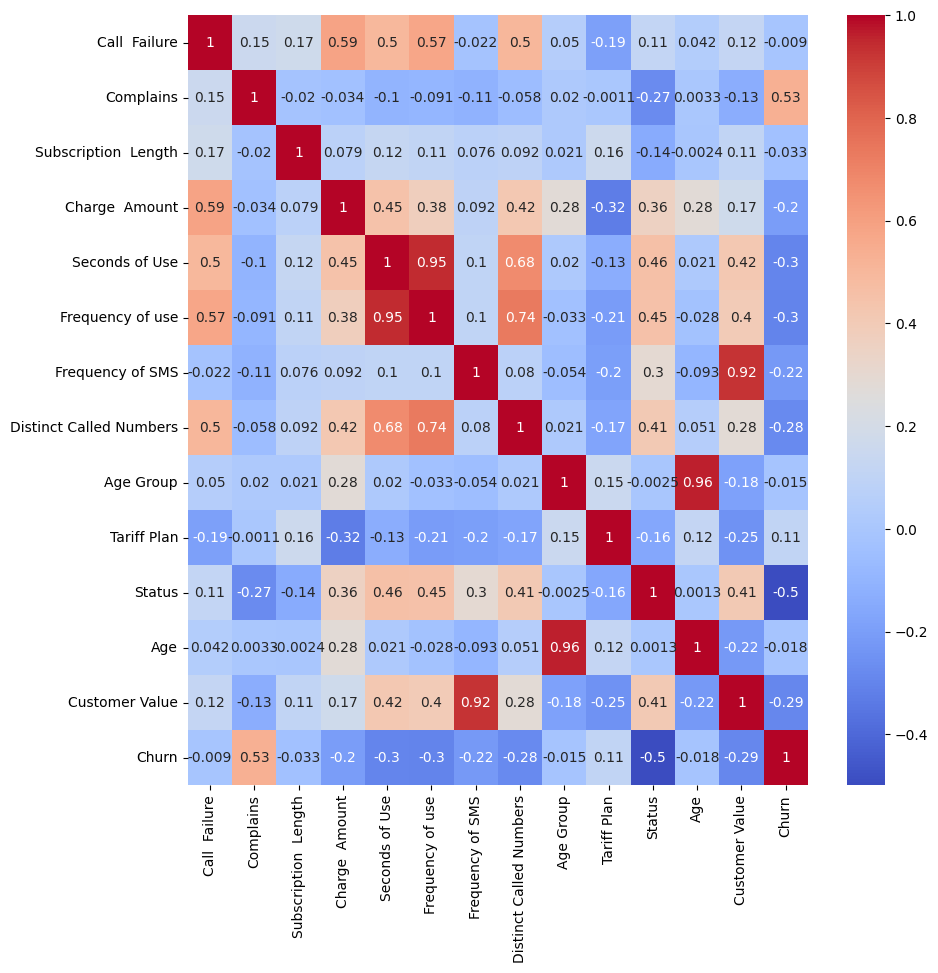

In [92]:
# Matriz de Correlacion de Pearson para relacionar variables numericas, no utilizaremos chi-cuadrado o ANOVA 
# Graficar Correlaciones
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(method="pearson"), annot=True, cmap='coolwarm')
plt.show()

In [93]:
# Según todas las pruebas y los Coeficientes de Pearson, parece indicar que Subscription Length no incide significativamente en Churn

### Actividad 3

Muestra la frecuencia de cada clase y realiza un balanceo de clase usando SMOTE. Divida el conjunto de datos en entrenamiento y test, considerando para este último un 33%.

In [94]:
print(f"Cantidad de muestras con churn = 0: {subscription_length_churn_mask_0.sum()}")
print(f"Cantidad de muestras con churn = 1: {subscription_length_churn_mask_1.sum()}")

Cantidad de muestras con churn = 0: 2655
Cantidad de muestras con churn = 1: 495


In [95]:
# Generar valores de X
X = df.drop(feature_target, axis=1)
X

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640
1,0,0,39,0,318,5,7,4,2,1,0,25,46.035
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,0,1,25,721.980
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640


In [96]:
# Generar valores de y
y = df[[feature_target]]
y

,Churn
0,0
1,0
2,0
3,0
4,0
...,...
3145,0
3146,0
3147,0
3148,0


In [97]:
# Generar Datos de Entrenamiento y Testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [98]:
# Aplicando SMOTE para balancear los datos de entrenamiento 
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [99]:
X_train_res

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
0,10,0,39,1,4313,72,33,39,1,1,1,15,422.675000
1,3,0,41,0,433,10,5,3,3,1,0,30,37.720000
2,4,0,35,0,8210,105,116,26,3,1,1,30,796.600000
3,2,0,9,1,4390,40,215,10,3,1,1,30,1037.200000
4,0,0,29,0,14920,166,128,22,2,1,1,25,1254.870000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3571,6,0,34,0,5192,88,4,22,2,1,1,25,258.063217
3572,15,1,38,0,2727,53,60,36,4,1,0,45,221.785948
3573,0,1,8,0,1367,17,2,8,2,1,1,25,75.720919
3574,0,0,36,0,386,3,7,4,4,1,0,45,29.324028


In [100]:
y_train_res

,Churn
0,0
1,0
2,0
3,0
4,0
...,...
3571,1
3572,1
3573,1
3574,1


In [101]:
y_train_res_churn_0 = y_train_res["Churn"] == 0
y_train_res_churn_1 = y_train_res["Churn"] == 1
print(f"Cantidad de clases 0: {y_train_res_churn_0.sum()}")
print(f"Cantidad de clases 1: {y_train_res_churn_1.sum()}")

Cantidad de clases 0: 1788
Cantidad de clases 1: 1788


### Actividad 4

Entrene un modelo RandomForest con hiper parámetros por defecto, usando el conjunto de entrenamiento anterior y muestra la métrica F1-Score para ambas clases en el conjunto de test. Captura y muestra las siete características más importantes detectadas por el modelo RandomForest.

In [102]:
# Resetear indices en datos de entrenamiento
X_train_res = X_train_res.reset_index(drop=True)
y_train_res = y_train_res.reset_index(drop=True)
y_train_res = y_train_res.to_numpy().ravel()

In [104]:
# Resetear indices en datos de testeo
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_test = y_test.to_numpy().ravel()

In [105]:
# Modelo
rf_clf = RandomForestClassifier(random_state=42)

# Entrenamiento
rf_clf.fit(X_train_res, y_train_res)

# Predecir
y_pred_rf_clf = rf_clf.predict(X_test)

# Dataframe de importancia de features
df_feature_importances = pd.DataFrame(rf_clf.feature_importances_, index= X_train_res.columns, columns= ["Importance"])
df_feature_importances["Importance"].sort_values(ascending=False).head(7)

Status                     0.204051
Seconds of Use             0.144375
Frequency of use           0.127001
Subscription  Length       0.095088
Customer Value             0.093040
Frequency of SMS           0.074712
Distinct Called Numbers    0.068317
Name: Importance, dtype: float64

In [106]:
# Reporte de Clasificacion

print(classification_report(y_test, y_pred_rf_clf))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       867
           1       0.82      0.87      0.85       173

    accuracy                           0.95      1040
   macro avg       0.90      0.92      0.91      1040
weighted avg       0.95      0.95      0.95      1040



In [107]:
# Al aplicar SMOTE se pueden observar buenas métricas para ambas clases 

### Actividad 5

Usando las siete características encontradas anteriormente, filtra el conjunto de entrenamiento y entrena un modelo de red neuronal feedforward con sólo una capa oculta. Para esto debes definir una función de activación adecuada, tanto para la capa oculta como para la capa de salida, la cantidad de neuronas a usar, la tasa de aprendizaje (learning_rate), y la cantidad de épocas deben ser ajustadas manualmente. Como optimizador, utiliza el Descenso del Gradiente Estocástico. Los ajustes manuales de los hiper parámetros deben ser tales que la métrica AUC sea mayor al 90%. Muestra finalmente ROC y su AUC.

In [108]:
X_train_res_filtered = X_train_res[["Status", "Seconds of Use", "Frequency of use", "Subscription  Length", "Customer Value", "Frequency of SMS", "Distinct Called Numbers"]]
X_test_filtered = X_test[["Status", "Seconds of Use", "Frequency of use", "Subscription  Length", "Customer Value", "Frequency of SMS", "Distinct Called Numbers"]]



In [109]:
X_train_res_filtered

,Status,Seconds of Use,Frequency of use,Subscription Length,Customer Value,Frequency of SMS,Distinct Called Numbers
0,1,4313,72,39,422.675000,33,39
1,0,433,10,41,37.720000,5,3
2,1,8210,105,35,796.600000,116,26
3,1,4390,40,9,1037.200000,215,10
4,1,14920,166,29,1254.870000,128,22
...,...,...,...,...,...,...,...
3571,1,5192,88,34,258.063217,4,22
3572,0,2727,53,38,221.785948,60,36
3573,1,1367,17,8,75.720919,2,8
3574,0,386,3,36,29.324028,7,4


In [110]:
X_test_filtered

,Status,Seconds of Use,Frequency of use,Subscription Length,Customer Value,Frequency of SMS,Distinct Called Numbers
0,1,7515,103,40,1108.720,201,28
1,1,7508,127,37,2071.575,384,43
2,1,3153,66,28,144.855,0,20
3,1,15850,234,33,737.280,3,82
4,1,9947,188,18,284.025,88,42
...,...,...,...,...,...,...,...
1035,1,7298,157,19,843.975,113,59
1036,1,4150,74,34,168.960,0,21
1037,1,3775,82,38,282.280,32,28
1038,1,11350,148,36,459.920,0,43


In [58]:
# Escalando columnas continuas
features_filtered_scalable = ["Seconds of Use", "Frequency of use", "Subscription  Length", "Customer Value", "Frequency of SMS", "Distinct Called Numbers"] 
features_filtered_not_scalable = ["Status"]
features_filtered = features_filtered_scalable + features_filtered_not_scalable

preprocessor = ColumnTransformer(
    transformers=[
        ('features_continuous', StandardScaler(), features_filtered_scalable)
    ],
    remainder='passthrough'  # deja pasar columnas no mencionadas
)

preprocessor.fit(X_train_res_filtered)
X_train_res_filtered_transformed = preprocessor.transform(X_train_res_filtered)
X_test_filtered_transformed = preprocessor.transform(X_test_filtered)

In [130]:
# Definir los hiperparámetros manualmente
learning_rate = 0.1
epochs = 300
batch_size = 32
n_features = X_train_res_filtered.shape[1]
validation_split = 0.2

# Creamos un modelo Secuencial
model_sequential = Sequential()

# Agregamos la capa de entrada
model_sequential.add(Input(shape=(n_features,))) 

# Capa oculta: 16 neuronas, activación ReLU (buena para clasificación binaria)
model_sequential.add(Dense(16, activation='relu'))

# Capa de salida: 1 neurona, activación sigmoid (porque es clasificación binaria)
model_sequential.add(Dense(1, activation='sigmoid'))

# Compilar el modelo usando Descenso del Gradiente Estocástico (SGD)
optimizer = SGD(learning_rate=learning_rate)

model_sequential.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(),  # función de pérdida para clasificación binaria
    metrics=[AUC(name='auc')]  # Queremos que AUC sea > 0.90
)

# Entrenar el modelo
history = model_sequential.fit(X_train_res_filtered_transformed, y_train_res, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)

# Evaluar en test
loss, auc = model_sequential.evaluate(X_test_filtered_transformed, y_test)
print(f'\n🔍 Evaluación en test:\nPérdida: {loss:.4f}, AUC: {auc:.4f}')

# Probabilidad de pertenencia a la clase 1
y_proba_model_sequential = model_sequential.predict(X_test_filtered_transformed)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9580 - loss: 0.1797

🔍 Evaluación en test:
Pérdida: 0.1797, AUC: 0.9580
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [131]:
y_pred_model_sequential = (y_proba_model_sequential > 0.5).astype("int32")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_model_sequential))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       867
           1       0.82      0.82      0.82       173

    accuracy                           0.94      1040
   macro avg       0.89      0.89      0.89      1040
weighted avg       0.94      0.94      0.94      1040



In [132]:
# Funciones para evaluar métricas

def model_evaluation_regressor(y_test, y_pred, model_name:str):
    dict_results = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    df = pd.DataFrame(dict_results, index=[f"{model_name}"])
    df.index.name = "Model"
    return df

def model_evaluation_classifier(y_test, y_pred, y_prob, model_name:str):
    dict_results = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    }

    df = pd.DataFrame(dict_results, index=[f"{model_name}"])
    df.index.name = "Model"
    return df

def shows_roc_curve(y_test, y_prob):
    # Graficar curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
    plt.plot([0,1], [0,1], 'k--', label="Línea aleatoria")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def show_metrics_models(df:pd.DataFrame):
    df.plot(kind='bar', figsize=(25,10))     # o df.plot.bar()
    plt.title("Modelos vs Métricas")
    plt.xlabel("Modelo")
    plt.ylabel("Valor Métrica")
    plt.xticks(rotation=0)  # etiquetas verticales (0 = horizontales)
    plt.legend(title="Métricas")
    plt.show()

def shows_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No', 'Pred: Sí'],
            yticklabels=['Real: No', 'Real: Sí'])
    plt.xlabel("Predicción del modelo")
    plt.ylabel("Valor real")
    plt.title("Matriz de Confusión")
    plt.show()

    print("Descripción Matriz de Confusión")
    print("---------------------------------")
    print(f"Falsos Positivos: {cm[0][1]}")
    print(f"Falsos Negativos: {cm[1][0]}")
    print(f"Verdaderos Positivos: {cm[1][1]}")
    print(f"Verdaderos Negativos: {cm[0][0]}")

In [133]:
# Evaluacion de desempeño con los datos de predicción
df_results_model_sequential = model_evaluation_classifier(y_test, y_pred_model_sequential, y_proba_model_sequential,"model_sequential")
df_results_model_sequential

,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
model_sequential,0.938462,0.815029,0.815029,0.815029,0.962961


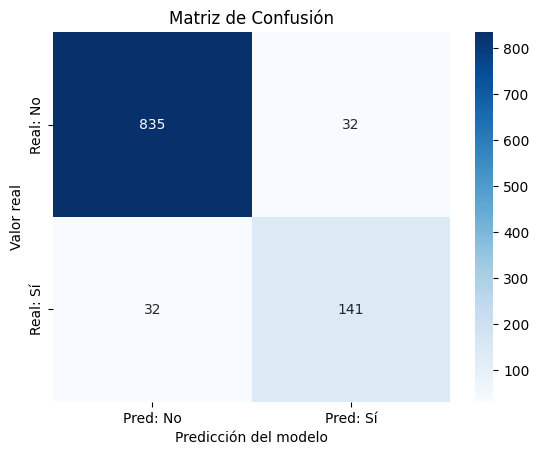

Descripción Matriz de Confusión
---------------------------------
Falsos Positivos: 32
Falsos Negativos: 32
Verdaderos Positivos: 141
Verdaderos Negativos: 835


In [134]:
# Matriz de confusion
shows_confusion_matrix(y_test, y_pred_model_sequential)

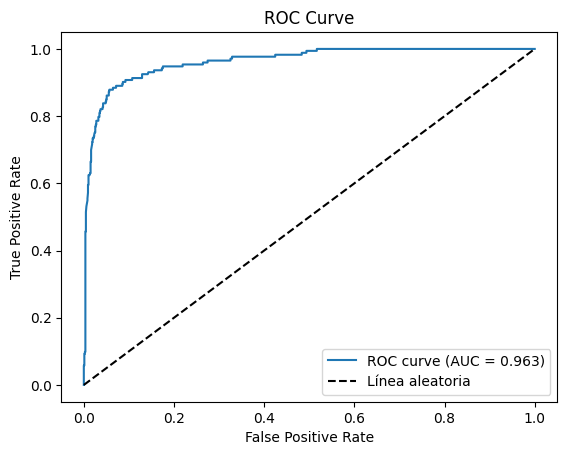

In [135]:
# Curva ROC
shows_roc_curve(y_test, y_proba_model_sequential)

In [137]:
# Guardando modelo
model_sequential.save('model_sequential.keras')